In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    confusion_matrix, 
    classification_report,
    roc_auc_score
)
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.multiclass import OneVsRestClassifier
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import warnings
import tqdm
import psutil
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(42)
torch.manual_seed(42)

In [3]:
DATA_ROOT = "../../data/images/images" 
TRAIN_DIR = os.path.join(DATA_ROOT, "train")
VAL_DIR = os.path.join(DATA_ROOT, "validation") 
TEST_DIR = "../../data/images/asd"
EMOTION_LABELS = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
BATCH_SIZE = 128
IMG_SIZE = 227 
NUM_WORKERS = 8



In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
print(torch.cuda.get_device_name())

cuda
NVIDIA GeForce RTX 3090 Ti


In [5]:
RF_N_ESTIMATORS = 300
RF_RANDOM_STATE = 42
RF_MAX_DEPTH = None
RF_MIN_SAMPLES_SPLIT = 2
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

In [6]:
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(degrees=90),
    transforms.RandomAdjustSharpness(sharpness_factor=2),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

In [7]:
class EmotionDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.images = []
        self.labels = []  
        for label_idx, emotion in enumerate(EMOTION_LABELS):
            emotion_dir = os.path.join(data_dir, emotion)
            if os.path.exists(emotion_dir):
                for img_name in os.listdir(emotion_dir):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        self.images.append(os.path.join(emotion_dir, img_name))
                        self.labels.append(label_idx)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [8]:
try:
    train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transform)
    val_dataset = datasets.ImageFolder(root=VAL_DIR, transform=val_test_transform)
    print(f"Jumlah data training: {len(train_dataset)}")
    print(f"Jumlah data validation: {len(val_dataset)}")
    print(f"Kelas yang terdeteksi: {train_dataset.classes}")
    
except Exception as e:
    
    train_dataset = EmotionDataset(TRAIN_DIR, transform=train_transform)
    val_dataset = EmotionDataset(VAL_DIR, transform=val_test_transform)
    
    print(f"Jumlah data training: {len(train_dataset)}")
    print(f"Jumlah data validation: {len(val_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
print(f"Batch size: {BATCH_SIZE}")

Jumlah data training: 63750
Jumlah data validation: 7066
Kelas yang terdeteksi: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Batch size: 128


In [9]:
class ResNet50FeatureExtractor(nn.Module):
    def __init__(self):
        super(ResNet50FeatureExtractor, self).__init__()
        self.resnet50 = models.resnet50(pretrained=True)        
        self.resnet50.fc = nn.Identity()
        
        for param in self.resnet50.parameters():
            param.requires_grad = False
    
    def forward(self, x):
        features = self.resnet50(x)
        return features

In [10]:
feature_extractor = ResNet50FeatureExtractor().to(device)
feature_extractor.eval()

ResNet50FeatureExtractor(
  (resnet50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequ

In [11]:
def extract_features_and_labels(dataloader, feature_extractor, device, balance_classes=True, balance_strategy='oversample'):
    """
    Ekstrak fitur dari seluruh dataset menggunakan ResNet50 - OPTIMIZED VERSION with CLASS BALANCING
    
    Args:
        dataloader: DataLoader untuk dataset
        feature_extractor: Model ResNet50 untuk ekstraksi fitur
        device: Device (CPU/GPU)
        balance_classes: Boolean, apakah akan balance class setelah ekstraksi
        balance_strategy: 'oversample', 'undersample', atau 'mixed'
    
    Returns:
        features_array: Array numpy berisi fitur yang diekstrak (balanced)
        labels_array: Array numpy berisi label (balanced)
    """
    feature_extractor.eval()
    all_features = []
    all_labels = []
    
    print("Memulai ekstraksi fitur...")
    print(f"   Batch size: {dataloader.batch_size}")
    print(f"   Total batches: {len(dataloader):,}")
    print(f"   Class balancing: {'Enabled' if balance_classes else 'Disabled'}")
    
    try:
        from tqdm import tqdm
        use_tqdm = True
        print("   Progress bar: Enabled (tqdm)")
    except ImportError:
        print("   Progress bar: Basic (install tqdm untuk progress bar yang lebih baik)")
        use_tqdm = False
    
    import time
    start_time = time.time()
    total_samples = 0
    
    with torch.no_grad():
        if use_tqdm:
            pbar = tqdm(dataloader, desc="Extracting Features", unit='batch',
                       bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]')
            iterator = pbar
        else:
            iterator = dataloader
            
        for batch_idx, (data, labels) in enumerate(iterator):
            batch_start = time.time()
            
            data = data.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True) if hasattr(labels, 'to') else labels
            
            features = feature_extractor(data)
            
            features_cpu = features.cpu()
            labels_cpu = labels.cpu() if hasattr(labels, 'cpu') else labels
            
            all_features.append(features_cpu.numpy())
            all_labels.append(labels_cpu.numpy() if hasattr(labels_cpu, 'numpy') else labels)
            
            total_samples += data.shape[0]
            batch_time = time.time() - batch_start
            samples_per_sec = data.shape[0] / batch_time
            
            if use_tqdm:
                pbar.set_postfix({
                    'samples/sec': f'{samples_per_sec:.0f}',
                    'GPU_mem': f'{torch.cuda.memory_allocated()/1e9:.1f}GB' if torch.cuda.is_available() else 'CPU'
                })
            else:
                if (batch_idx + 1) % 50 == 0:
                    elapsed = time.time() - start_time
                    avg_time = elapsed / (batch_idx + 1)
                    remaining = avg_time * (len(dataloader) - batch_idx - 1)
                    print(f"Batch {batch_idx + 1}/{len(dataloader)} | "
                          f"{samples_per_sec:.0f} samples/sec | "
                          f"ETA: {remaining/60:.1f}m")
            
            if (batch_idx + 1) % 200 == 0 and torch.cuda.is_available():
                torch.cuda.empty_cache()
    
    print(f"\nMenggabungkan {len(all_features)} batch...")
    concat_start = time.time()
    
    features_array = np.vstack(all_features)
    labels_array = np.concatenate(all_labels)
    
    concat_time = time.time() - concat_start
    total_time = time.time() - start_time
    
    print(f"Ekstraksi fitur selesai!")
    print(f"   Total samples: {total_samples:,}")
    print(f"   Features shape: {features_array.shape}")
    print(f"   Total time: {total_time/60:.1f} menit")
    print(f"   Speed: {total_samples/total_time:.0f} samples/second")
    print(f"   Concatenation: {concat_time:.1f} seconds")
    
    if balance_classes:
        print(f"\n MEMULAI CLASS BALANCING...")
        balance_start = time.time()
        
        unique_labels, counts = np.unique(labels_array, return_counts=True)
        print(f" DISTRIBUSI ORIGINAL:")
        for label, count in zip(unique_labels, counts):
            class_name = EMOTION_LABELS[label] if label < len(EMOTION_LABELS) else f"Class_{label}"
            percentage = count / len(labels_array) * 100
            print(f"   {class_name}: {count:,} samples ({percentage:.1f}%)")
        
        if balance_strategy == 'oversample':
            target_size = np.max(counts)  
            print(f"Strategy: Oversample ke {target_size:,} samples per class")
        elif balance_strategy == 'undersample':
            target_size = np.min(counts)    
            print(f"Strategy: Undersample ke {target_size:,} samples per class")
        else:  
            target_size = int(np.mean(counts))  
            print(f"Strategy: Mixed sampling ke {target_size:,} samples per class")
        
        balanced_features = []
        balanced_labels = []
        
        np.random.seed(42) 
        
        for label in unique_labels:
            class_indices = np.where(labels_array == label)[0]
            class_features = features_array[class_indices]
            class_labels = labels_array[class_indices]
            
            current_size = len(class_indices)
            class_name = EMOTION_LABELS[label] if label < len(EMOTION_LABELS) else f"Class_{label}"
            
            if current_size >= target_size:
                selected_indices = np.random.choice(current_size, target_size, replace=False)
                sampled_features = class_features[selected_indices]
                sampled_labels = class_labels[selected_indices]
                print(f"   {class_name}: {current_size:,} → {target_size:,} (undersampled)")
            else:
                selected_indices = np.random.choice(current_size, target_size, replace=True)
                sampled_features = class_features[selected_indices]
                sampled_labels = class_labels[selected_indices]
                print(f"   {class_name}: {current_size:,} → {target_size:,} (oversampled)")
            
            balanced_features.append(sampled_features)
            balanced_labels.append(sampled_labels)
        
        features_array = np.vstack(balanced_features)
        labels_array = np.concatenate(balanced_labels)
        
        shuffle_indices = np.random.permutation(len(features_array))
        features_array = features_array[shuffle_indices]
        labels_array = labels_array[shuffle_indices]
        
        balance_time = time.time() - balance_start
        
        print(f"\nCLASS BALANCING SELESAI!")
        print(f"   Balanced samples: {len(features_array):,}")
        print(f"   Balanced shape: {features_array.shape}")
        print(f"   Balancing time: {balance_time:.1f} seconds")
        
        print(f"\nDISTRIBUSI SETELAH BALANCING:")
        unique_balanced, counts_balanced = np.unique(labels_array, return_counts=True)
        for label, count in zip(unique_balanced, counts_balanced):
            class_name = EMOTION_LABELS[label] if label < len(EMOTION_LABELS) else f"Class_{label}"
            percentage = count / len(labels_array) * 100
            print(f"   {class_name}: {count:,} samples ({percentage:.1f}%) =")
    
    del all_features, all_labels
    if balance_classes:
        del balanced_features, balanced_labels
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    return features_array, labels_array


In [12]:
print("=== EKSTRAKSI FITUR DATASET TRAINING ===")
X_train, y_train = extract_features_and_labels(train_loader, feature_extractor, device,balance_classes=True, balance_strategy='oversample')

print("\n=== EKSTRAKSI FITUR DATASET VALIDATION ===")
X_val, y_val = extract_features_and_labels(val_loader, feature_extractor, device,balance_classes=False)


print(f"Training features: {X_train.shape}, labels: {y_train.shape}")
print(f"Validation features: {X_val.shape}, labels: {y_val.shape}")


=== EKSTRAKSI FITUR DATASET TRAINING ===
Memulai ekstraksi fitur...
   Batch size: 128
   Total batches: 499
   Class balancing: Enabled
   Progress bar: Enabled (tqdm)


Extracting Features: 100%|██████████| 499/499 [01:45<00:00,  4.72batch/s]



Menggabungkan 499 batch...
Ekstraksi fitur selesai!
   Total samples: 63,750
   Features shape: (63750, 2048)
   Total time: 1.8 menit
   Speed: 603 samples/second
   Concatenation: 0.1 seconds

 MEMULAI CLASS BALANCING...
 DISTRIBUSI ORIGINAL:
   angry: 7,988 samples (12.5%)
   disgust: 983 samples (1.5%)
   fear: 9,224 samples (14.5%)
   happy: 16,153 samples (25.3%)
   neutral: 11,180 samples (17.5%)
   sad: 11,015 samples (17.3%)
   surprise: 7,207 samples (11.3%)
Strategy: Oversample ke 16,153 samples per class
   angry: 7,988 → 16,153 (oversampled)
   disgust: 983 → 16,153 (oversampled)
   fear: 9,224 → 16,153 (oversampled)
   happy: 16,153 → 16,153 (undersampled)
   neutral: 11,180 → 16,153 (oversampled)
   sad: 11,015 → 16,153 (oversampled)
   surprise: 7,207 → 16,153 (oversampled)

CLASS BALANCING SELESAI!
   Balanced samples: 113,071
   Balanced shape: (113071, 2048)
   Balancing time: 0.6 seconds

DISTRIBUSI SETELAH BALANCING:
   angry: 16,153 samples (14.3%) =
   disgust: 

Extracting Features: 100%|██████████| 56/56 [00:32<00:00,  1.74batch/s]


Menggabungkan 56 batch...
Ekstraksi fitur selesai!
   Total samples: 7,066
   Features shape: (7066, 2048)
   Total time: 0.5 menit
   Speed: 219 samples/second
   Concatenation: 0.0 seconds
Training features: (113071, 2048), labels: (113071,)
Validation features: (7066, 2048), labels: (7066,)


In [13]:
unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_val, counts_val = np.unique(y_val, return_counts=True)

print("Train data distribution")
for i, (label, count) in enumerate (zip(unique_train, counts_train)):
    percentage = count / len(y_train) * 100
    class_name = EMOTION_LABELS[label] if label < len(EMOTION_LABELS) else f"class_{label}"
    status = "sever imbalance" if percentage < 5 else " imbalanced" if percentage < 10 else " OK!"
    print(f" {class_name}: {count:,} samples ({percentage:.1f}%) {status}")

print("Validation data distribution")

for i, (label, count) in enumerate (zip(unique_val, counts_val)):
    percentage = count / len(y_val) * 100
    class_name = EMOTION_LABELS[label] if label < len(EMOTION_LABELS) else f"class_{label}"
    print(f" {class_name}: {count:,} samples ({percentage:.1f}%)")

max_count = np.max(counts_train)
min_count = np.min(counts_train) 
imbalance_ratio = max_count / min_count

print(f"\n IMBALANCE ANALYSIS:")
print(f"   Imbalance ratio: {imbalance_ratio:.1f}:1")
if imbalance_ratio > 10:
    print(f"    SEVERE CLASS IMBALANCE detected!")
    print(f"    Solution: Use class_weight='balanced' in Random Forest")
elif imbalance_ratio > 5:
    print(f"    MODERATE CLASS IMBALANCE detected!")
    print(f"    Solution: Use class balancing techniques")


Train data distribution
 angry: 16,153 samples (14.3%)  OK!
 disgust: 16,153 samples (14.3%)  OK!
 fear: 16,153 samples (14.3%)  OK!
 happy: 16,153 samples (14.3%)  OK!
 neutral: 16,153 samples (14.3%)  OK!
 sad: 16,153 samples (14.3%)  OK!
 surprise: 16,153 samples (14.3%)  OK!
Validation data distribution
 angry: 960 samples (13.6%)
 disgust: 111 samples (1.6%)
 fear: 1,018 samples (14.4%)
 happy: 1,825 samples (25.8%)
 neutral: 1,216 samples (17.2%)
 sad: 1,139 samples (16.1%)
 surprise: 797 samples (11.3%)

 IMBALANCE ANALYSIS:
   Imbalance ratio: 1.0:1


In [14]:
rf_classifier = RandomForestClassifier(
    n_estimators=RF_N_ESTIMATORS,
    random_state=RF_RANDOM_STATE,
    max_depth=RF_MAX_DEPTH,
    min_samples_split=RF_MIN_SAMPLES_SPLIT,
    n_jobs=-1,  
    verbose=1   
)

print(f"Parameter Random Forest:")
print(f"- n_estimators: {RF_N_ESTIMATORS}")
print(f"- random_state: {RF_RANDOM_STATE}")
print(f"- max_depth: {RF_MAX_DEPTH}")
print(f"- min_samples_split: {RF_MIN_SAMPLES_SPLIT}")

Parameter Random Forest:
- n_estimators: 300
- random_state: 42
- max_depth: None
- min_samples_split: 2


In [15]:
rf_classifier.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.7min finished


,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [16]:
val_predictions = rf_classifier.predict(X_val)
val_probabilities = rf_classifier.predict_proba(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)
val_f1 = f1_score(y_val, val_predictions, average='weighted')

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.1s finished


In [17]:
val_accuracy = accuracy_score(y_val, val_predictions)
val_f1_weighted = f1_score(y_val, val_predictions, average='weighted')
val_f1_macro = f1_score(y_val, val_predictions, average='macro')

In [18]:
print(f"\n=== CLASSIFICATION REPORT ===")
class_names = EMOTION_LABELS if hasattr(train_dataset, 'classes') else [f'Class_{i}' for i in range(len(EMOTION_LABELS))]
print(classification_report(y_val, val_predictions, target_names=class_names))


=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

       angry       0.36      0.04      0.06       960
     disgust       1.00      0.02      0.04       111
        fear       0.39      0.08      0.14      1018
       happy       0.39      0.81      0.53      1825
     neutral       0.33      0.44      0.38      1216
         sad       0.35      0.24      0.28      1139
    surprise       0.54      0.40      0.46       797

    accuracy                           0.38      7066
   macro avg       0.48      0.29      0.27      7066
weighted avg       0.40      0.38      0.33      7066



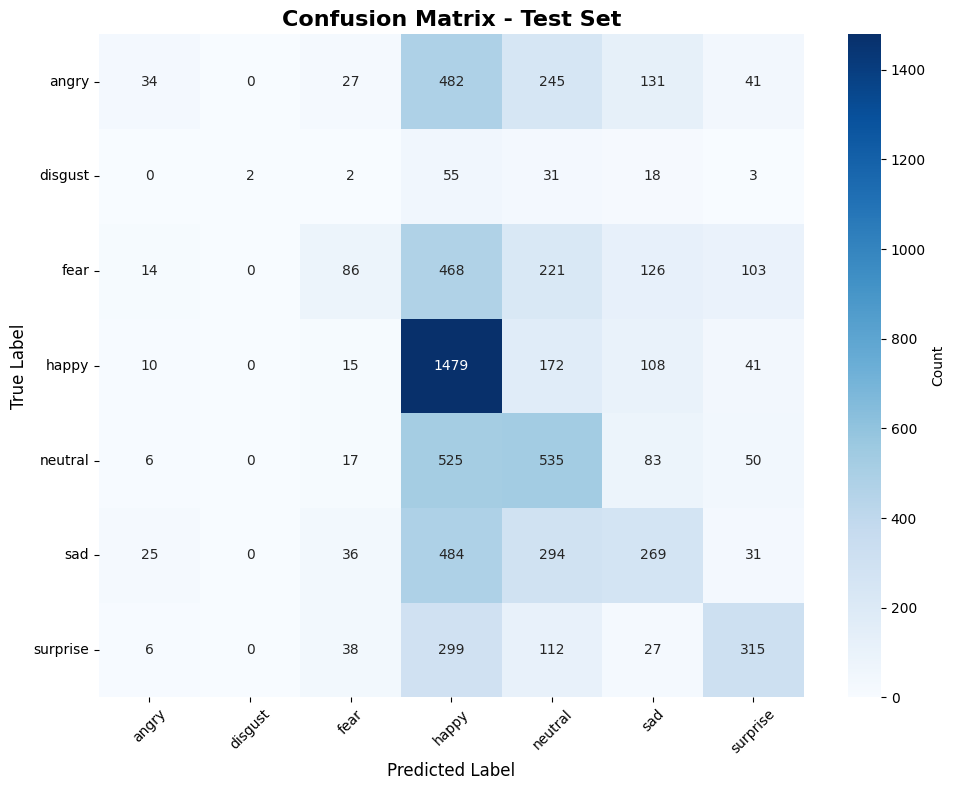

In [19]:
cm = confusion_matrix(y_val, val_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar_kws={'label': 'Count'})

plt.title('Confusion Matrix - Test Set', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [20]:
y_val_binary = label_binarize(y_val, classes=range(len(class_names)))
n_classes = y_val_binary.shape[1]
try:
    roc_auc_ovr = roc_auc_score(y_val_binary, val_probabilities, 
                                multi_class='ovr', average='weighted')
    print(f"ROC AUC Score (One-vs-Rest, weighted): {roc_auc_ovr:.4f}")
    roc_auc_ovo = roc_auc_score(y_val, val_predictions, 
                                multi_class='ovo', average='weighted')
    print(f"ROC AUC Score (One-vs-One, weighted): {roc_auc_ovo:.4f}")
    
except Exception as e:
    print(f"Error menghitung ROC AUC: {e}")
    print("Kemungkinan karena ada kelas yang tidak muncul di test set")
    
    print("\nMenghitung ROC AUC per kelas:")
    for i in range(n_classes):
        if len(np.unique(y_val_binary[:, i])) > 1:  
            auc = roc_auc_score(y_val_binary[:, i], val_probabilities[:, i])
            print(f"{class_names[i]}: {auc:.4f}")

ROC AUC Score (One-vs-Rest, weighted): 0.7192
Error menghitung ROC AUC: axis 1 is out of bounds for array of dimension 1
Kemungkinan karena ada kelas yang tidak muncul di test set

Menghitung ROC AUC per kelas:
angry: 0.6462
disgust: 0.7263
fear: 0.6423
happy: 0.7754
neutral: 0.7276
sad: 0.6704
surprise: 0.8329
